<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/covid19model_ex_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare for package

In [4]:
# !pip install tensorflow==1.13.1
!pip install tensorflow==1.15.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 40 kB/s 
     |████████████████████████████████| 503 kB 51.8 MB/s 
     |████████████████████████████████| 3.8 MB 49.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=07b36c7726e25d1cb7733477d2a983a76715fbc921102e27cececd69e2f68875
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.13.1
    Uninstalling tensorboard-1.13.1:
      Successfully uninstalled tensorboard-1.13.1
  Attempting uninstall: gast
    Found existing installation: gas

In [1]:
import tensorflow as tf
print( tf.__version__ )

1.15.2


# Load files

In [3]:
!cp -r 'drive/MyDrive/covid/models/' .

In [4]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [5]:
!cp -r 'drive/MyDrive/covid/assets/' .

# Grad-cam using tenserflow

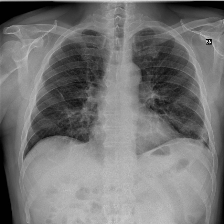

In [8]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

# imagepath = './covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg'
imagepath = "assets/ex-covid.jpeg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.01225144 0.98774856]]
Prediction: positive
Confidence
Negative: 0.012 Positive: 0.988
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


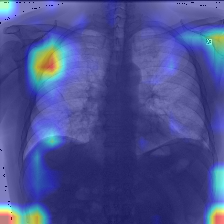

In [1]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  
#post_relu/Relu,post_bn/cond/FusedBatchNorm, conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


# Comparation

## Load other dataset

In [3]:
# covid-chestxray-dataset
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

--2022-11-23 22:25:17--  https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master [following]
--2022-11-23 22:25:17--  https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [            <=>     ] 525.03M  19.2MB/s    in 27s     

2022-11-23 22:25:44 (19.4 MB/s) - ‘master.zip’ saved [550535079]



In [4]:
!unzip master.zip

Archive:  master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
   creating: covid-chestxray-dataset-master/
   creating: covid-chestxray-dataset-master/.github/
 extracting: covid-chestxray-dataset-master/.github/FUNDING.yml  
   creating: covid-chestxray-dataset-master/.github/workflows/
  inflating: covid-chestxray-dataset-master/.github/workflows/tests.yml  
  inflating: covid-chestxray-dataset-master/.gitignore  
  inflating: covid-chestxray-dataset-master/README.md  
  inflating: covid-chestxray-dataset-master/SCHEMA.md  
   creating: covid-chestxray-dataset-master/annotations/
  inflating: covid-chestxray-dataset-master/annotations/covid-severity-scores.csv  
  inflating: covid-chestxray-dataset-master/annotations/imageannotation_ai_lung_bounding_boxes.json  
   creating: covid-chestxray-dataset-master/annotations/lungVAE-masks/
  inflating: covid-chestxray-dataset-master/annotations/lungVAE-masks/1-s2.0-S0140673620303706-fx1_lrg_mask.png  
  inflating: covid-chestxray-dataset-mas

## Test
- All the images highly might be detected as positive since they came from an *open dataset of chest X-ray and CT images of patients which are positive or suspected of COVID-19 or other viral and bacterial pneumonias* ([https://github.com/ieee8023/covid-chestxray-dataset/](https://github.com/ieee8023/covid-chestxray-dataset/)).

In [2]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import os, argparse

from google.colab.patches import cv2_imshow
def show_org(IMAGE_PATH):
  imagepath = IMAGE_PATH
  img_m = cv.imread(imagepath)
  img_m = cv.resize(img_m, (224, 224))
  # display(Image(imagepath))
  cv2_imshow(img_m)
  

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def main_grad_cam(IMAGE_PATH, MODEL_NAME):
  # arguments:
  IMAGE_PATH = IMAGE_PATH
  output_node_names = "norm_dense_2/Softmax"
  final_conv_name="conv5_block3_1_conv/convolution"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
  model_path = MODEL_NAME

  # USE COVIDNet CXR 2
  args_weightspath = 'models/COVIDNet-CXR-2' 
  args_metaname = 'model.meta'
  args_ckptname = 'model'
  args_n_classes = 2

  args_testfolder = 'data/test'
  args_trainfile = 'labels/train_COVIDx9B.txt'
  args_testfile = 'labels/test_COVIDx9B.txt'

  args_out_tensorname = 'norm_dense_2/Softmax:0'
  args_logit_tensorname = 'norm_dense_2/MatMul:0'
  args_is_severity_model = False
  args_is_medusa_backbone = False

  args_in_tensorname = 'input_1:0'
  args_in_tensorname_medusa = 'input_1:0'
  args_input_size = 480
  args_input_size_medusa = 256
  args_top_percent = 0.08

  # ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
  saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

  with tf.Session() as sess:
      saver.restore(sess, model_path)  # load arguments using restore automatically


      img_m_0 = cv.imread(IMAGE_PATH)
      img_m_0 = cv.resize(img_m_0, (224, 224))
      # img_m = tf.cast(img_m_0, tf.float32)
      # img_m = tf.reshape(img_m, [224, 224, 3])
      # img_m_f= sess.run([img_m])
      # print("img_m4", img_m)  # shape 480,480,3
      # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

      '''
      /////////////////////////////////////////// inference related
      '''
      
      if args_is_severity_model:
        # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
        mapping = {'level2': 0, 'level1': 1}
        inv_mapping = {0: 'level2', 1: 'level1'}
      elif args_n_classes == 2:
        # For COVID-19 positive/negative detection
        mapping = {'negative': 0, 'positive': 1}
        inv_mapping = {0: 'negative', 1: 'positive'}
      elif args_n_classes == 3:
        # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
        mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
        inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
      else:
        raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
            or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

      '''
      \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
      '''

      image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
      pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
      
      if args_is_medusa_backbone:
          x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
          x = x.astype('float32') / 255.0
          medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
          medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
          feed_dict = {
                      medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                      image_tensor: np.expand_dims(x, axis=0),
                  } 
          # print("args_is_medusa_backbone")
      else:
          x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
          x = x.astype('float32') / 255.0
          feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
          # print("Not args_is_medusa_backbone")
      pred = sess.run(pred_tensor, feed_dict=feed_dict)
      print("pred", pred)

      print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
      print('Confidence')
      print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
      print('**DISCLAIMER**')
      print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

      
      # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
      # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

      # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
      # x = x.astype('float32') / 255.0
      # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
      # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

      cam=grad_cam(prob_name=output_node_names, label=0, 
                    layer_name=final_conv_name, sess=sess, 
                    feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                    nb_classes=2)

      # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
      image_batch = img_m_0[None, :, :, :3]
      image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

      dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
      cv2_imshow(dst_m)
      # cv.imshow('dst_m_v',dst_m)
      cv.waitKey(0)


### 000001-1.jpg
- ./covid-chestxray-dataset-master/images/000001-1.jpg
- result for inference:
```
pred [[0.8663935  0.13360655]]
Prediction: negative
Confidence
Negative: 0.866 Positive: 0.134
```



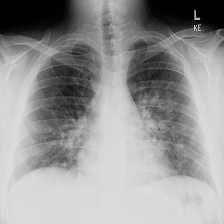

In [10]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/000001-1.jpg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.8663935  0.13360652]]
Prediction: negative
Confidence
Negative: 0.866 Positive: 0.134
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


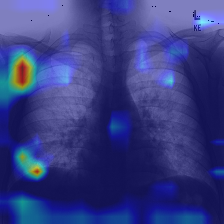

In [3]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH = "./covid-chestxray-dataset-master/images/000001-1.jpg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


### nejmoa2001191_f5-PA.jpeg
- ./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg
- result for inference:
```
pred [[2.3010748e-06 9.9999774e-01]]
Prediction: positive
Confidence
Negative: 0.000 Positive: 1.000
```

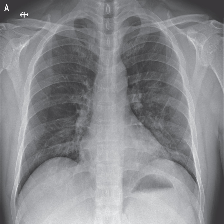

In [5]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[2.3010705e-06 9.9999774e-01]]
Prediction: positive
Confidence
Negative: 0.000 Positive: 1.000
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


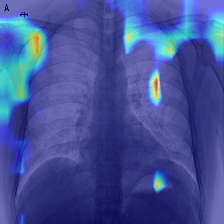

In [4]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="./covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


### 000002-1.jpg
- "./covid-chestxray-dataset-master/images/000002-1.jpg"
- result for inference:
```
pred [[0.00674177 0.99325824]]
Prediction: positive
Confidence
Negative: 0.007 Positive: 0.993
```

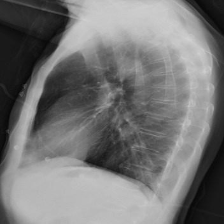

In [11]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

imagepath = "./covid-chestxray-dataset-master/images/000002-1.jpg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.0067418  0.99325824]]
Prediction: positive
Confidence
Negative: 0.007 Positive: 0.993
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


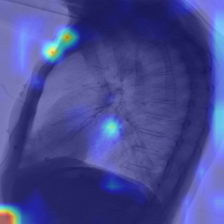

In [5]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="./covid-chestxray-dataset-master/images/000002-1.jpg"
output_node_names = "norm_dense_2/Softmax"
final_conv_name="post_relu/Relu"  #conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
model_path = 'models/COVIDNet-CXR-2/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-2' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'norm_dense_2/Softmax:0'
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
# saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name("input_1:0") # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name('norm_dense_2/Softmax:0') # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)


## Change model

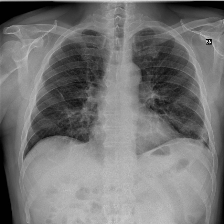

In [17]:
# show original photo
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
from google.colab.patches import cv2_imshow

# imagepath = './covid-chestxray-dataset-master/images/nejmoa2001191_f5-PA.jpeg'
imagepath = "assets/ex-covid.jpeg"
img_m = cv.imread(imagepath)
img_m = cv.resize(img_m, (224, 224))

# display(Image(imagepath))
cv2_imshow(img_m)

pred [[0.00833317 0.99166685]]
Prediction: positive
Confidence
Negative: 0.008 Positive: 0.992
**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


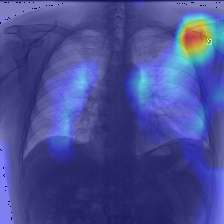

In [1]:
import cv2 as cv
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import os, argparse

from google.colab.patches import cv2_imshow

# def for inference
def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img

def process_image_file_medusa(filepath, size):
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (size, size))
    img = img.astype('float64')
    img -= img.mean()
    img /= img.std()
    return np.expand_dims(img, -1)

# def for grad cam
def grad_cam(prob_name, label, layer_name, sess, feed_dict, nb_classes):
    """
    prob_name: the name of softmax layer, label: name for label, 
    layer_name: the name of the last layer, sess,                 
    feed_dict, nb_classes: number of classes
    related url: https://github.com/cydonia999/Grad-CAM-in-TensorFlow/blob/master/grad-cam-tf.py
    """
 
    prob = sess.graph.get_tensor_by_name(prob_name + ':0')
    loss = tf.multiply(prob, tf.one_hot([label], nb_classes))
    
    reduced_loss = tf.reduce_sum(loss[0]) # reduced_loss = tf.reduce_sum(loss, axis=1) 
    conv_output = sess.graph.get_tensor_by_name(layer_name + ':0')
    images = tf.placeholder("float", [None, 224, 224, 3])
    grads = tf.gradients(reduced_loss, conv_output)[0] # grads = tf.gradients(reduced_loss, conv_output)[0] # d loss / d conv
    output, grads_val = sess.run([conv_output, grads], feed_dict=feed_dict)
    # output = sess.run(conv_output, feed_dict=feed_dict)
    # grads_val = sess.run(grads, feed_dict=feed_dict)
    weights = np.mean(grads_val, axis=(1,2))   # weights = np.mean(grads_val, axis=(1, 2)) # average pooling
    cams = np.sum(weights * output, axis=3)  # axis=3

    return cams
 
 
def save_cam(cam, image, save_path):
    """
    save Grad-CAM images
    """
    cam = cam[0]  # cam = cam[0] # the first GRAD-CAM for the first image in  batch
    # image = np.uint8(image_batch[0][:, :, ::-1] * 255.0) # RGB -> BGR
    cam = cv.resize(cam, (224, 224)) # enlarge heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam) # normalize
    cam = cv.applyColorMap(np.uint8(255 * heatmap), cv.COLORMAP_JET) 
    cam = np.float32(cam) + np.float32(image) # everlay heatmap onto the image
    cam = 255 * cam / np.max(cam)
    cam = np.uint8(cam)
    
    cv.imwrite(save_path+"cam.jpg", cam)
    cv.imwrite(save_path+"heatmap.jpg", (heatmap * 255.0).astype(np.uint8))
    cv.imwrite(save_path+"segmentation.jpg", (heatmap[:, :, None].astype(float) * image).astype(np.uint8))
 
    return  cam

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv.imread(filepath)
    # print("filepath", filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv.resize(img, (size, size))
    return img


 
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "softmax/Softmax"
final_conv_name="private__identity_block_11/Relu_2"  
#private__identity_block_11/add, private__identity_block_11/Relu_2
model_path = 'models/COVIDNet-CXR-3/model'

# USE COVIDNet CXR 2
args_weightspath = 'models/COVIDNet-CXR-3' 
args_metaname = 'model.meta'
args_ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'softmax/Softmax:0'
# args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = True

args_in_tensorname = 'input_2:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 480
args_input_size_medusa = 256
args_top_percent = 0.08


# ckpt = tf.train.get_checkpoint_state(model_path)  # through checkpoint file to locate the model
saver = tf.train.import_meta_graph(model_path + '.meta')  # load graph structure, saved in .meta file

with tf.Session() as sess:
    saver.restore(sess, model_path)  # load arguments using restore automatically


    img_m_0 = cv.imread(IMAGE_PATH)
    img_m_0 = cv.resize(img_m_0, (224, 224))
    # img_m = tf.cast(img_m_0, tf.float32)
    # img_m = tf.reshape(img_m, [224, 224, 3])
    # img_m_f= sess.run([img_m])
    # print("img_m4", img_m)  # shape 480,480,3
    # print("img_m_f", img_m_f)  # shape 1,1,480,480,3

    '''
    /////////////////////////////////////////// inference related
    '''
    
    if args_is_severity_model:
      # For COVIDNet CXR-S training with COVIDxSev level 1 and level 2 air space seveirty grading
      mapping = {'level2': 0, 'level1': 1}
      inv_mapping = {0: 'level2', 1: 'level1'}
    elif args_n_classes == 2:
      # For COVID-19 positive/negative detection
      mapping = {'negative': 0, 'positive': 1}
      inv_mapping = {0: 'negative', 1: 'positive'}
    elif args_n_classes == 3:
      # For detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia
      mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
      inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}
    else:
      raise Exception('''COVID-Net currently only supports 2 class COVID-19 positive/negative detection
          or 3 class detection of no pneumonia/non-COVID-19 pneumonia/COVID-19 pneumonia''')

    '''
    \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''

    image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname) # args_in_tensorname "input_1:0"
    pred_tensor = sess.graph.get_tensor_by_name(args_out_tensorname) # args_out_tensorname 'norm_dense_2/Softmax:0'
    
    if args_is_medusa_backbone:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=0, crop=False)
        x = x.astype('float32') / 255.0
        medusa_image_tensor = sess.graph.get_tensor_by_name(args_in_tensorname_medusa)
        medusa_x = process_image_file_medusa(IMAGE_PATH, args_input_size_medusa)
        feed_dict = {
                    medusa_image_tensor: np.expand_dims(medusa_x, axis=0),
                    image_tensor: np.expand_dims(x, axis=0),
                } 
        # print("args_is_medusa_backbone")
    else:
        x = process_image_file(IMAGE_PATH, args_input_size, top_percent=args_top_percent)
        x = x.astype('float32') / 255.0
        feed_dict = {image_tensor: np.expand_dims(x, axis=0)}
        # print("Not args_is_medusa_backbone")
    pred = sess.run(pred_tensor, feed_dict=feed_dict)
    print("pred", pred)

    print('Prediction: {}'.format(inv_mapping[pred.argmax(axis=1)[0]]))
    print('Confidence')
    print(' '.join('{}: {:.3f}'.format(cls.capitalize(), pred[0][i]) for cls, i in mapping.items()))
    print('**DISCLAIMER**')
    print('Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.')

    
    # input_image_tensor_m = sess.graph.get_tensor_by_name("input_1:0")
    # # input_is_training_tensor = sess.graph.get_tensor_by_name("input/is_training:0")

    # x = process_image_file(IMAGE_PATH, 480, top_percent=0.08) # IMAGE_PATH = 'assets/ex-covid.jpeg'
    # x = x.astype('float32') / 255.0
    # # feed_dict = {input_image_tensor_m: np.expand_dims(x, axis=0)}
    # # print("np.expand_dims(x, axis=0)", np.expand_dims(x, axis=0))

    cam=grad_cam(prob_name=output_node_names, label=0, 
                  layer_name=final_conv_name, sess=sess, 
                  feed_dict=feed_dict, # feed_dict={input_image_tensor_m: np.expand_dims(x, axis=0)}, 
                  nb_classes=2)

    # feed_dict={input_image_tensor_m: [img_m_f], input_is_training_tensor: False}
    image_batch = img_m_0[None, :, :, :3]
    image = np.uint8(image_batch[0][:, :, ::-1] * 255.0)

    dst_m=save_cam(cam, image, 'm')  # cam, img_m, 'm'
    cv2_imshow(dst_m)
    # cv.imshow('dst_m_v',dst_m)
    cv.waitKey(0)
